<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/6b_ac_quita_ruido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocodificadores quita ruido


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras import Model, Sequential
from tensorflow.keras.regularizers import l1

tf.keras.backend.set_floatx('float64')

np.random.seed(1)
tf.random.set_seed(2)

TensorFlow 2.x selected.


## Carga de datos
Se carga y preprocesan las imágenes del conjunto Fashion MNIST:

In [0]:
(I_ent, y_ent), (I_val, y_val) = fashion_mnist.load_data()
X_ent = I_ent.reshape(I_ent.shape[0], 784) / 255
X_val = I_val.reshape(I_val.shape[0], 784) / 255

Se define función de mapeo para la generación de una versión ruidosa de cada imagen:

In [0]:
def procesa_imagen(imagen):
  imagen = tf.cast(imagen, tf.float64)
  ruido = tf.random.normal(imagen.shape, mean=0.2, stddev=0.3, dtype=tf.float64)
  imagen_ruido = imagen + ruido
  return imagen_ruido, imagen

Se genera la tubería de datos:

In [0]:
ent_ds = tf.data.Dataset.from_tensor_slices((X_ent))
ent_ds = ent_ds.shuffle(60000)
ent_ds = ent_ds.map(procesa_imagen, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ent_ds = ent_ds.batch(64)
ent_ds = ent_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val))
val_ds = val_ds.map(procesa_imagen, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(1)

## Autocodificador contractivo
Se define un autocodificador quita ruido contractivo:

In [0]:
cod = Sequential([Dense(100, activation='sigmoid', input_shape=(784,)),
                  Dense(50, activation='sigmoid'),
                  Dense(20, activation='sigmoid'),
                  Dense(10, activation='sigmoid')])
dec = Sequential([Dense(20, activation='sigmoid', input_shape=(10,)),
                  Dense(50, activation='sigmoid'),
                  Dense(100, activation='sigmoid'),
                  Dense(784, activation='sigmoid')])
ac = Model(cod.inputs, dec(cod.outputs))
ac.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               85554     
Total params: 170,334
Trainable params: 170,334
Non-trainable params: 0
_______________________________________________________

Se entrena el autocodificador por 3 épocas con el optimizador Adam y función de pérdida de error cuadrático medio:

In [0]:
@tf.function
def paso_ent(x, y, modelo, fn_perdida, optimizador):
    with tf.GradientTape() as cinta:
        y_pred = modelo(x)
        perdida = fn_perdida(y, y_pred)
    gradientes = cinta.gradient(perdida, modelo.trainable_variables)
    optimizador.apply_gradients(zip(gradientes, modelo.trainable_variables))
    return y_pred

fn_perdida = tf.keras.losses.MeanSquaredError()
optimizador = tf.keras.optimizers.Adam()
perdida_ent = tf.keras.metrics.MeanSquaredError()
hist_perdida_ent = []
for epoca in range(3):
    for paso, (x, y) in enumerate(ent_ds):
        y_pred = paso_ent(x, y,  ac, fn_perdida, optimizador)
        perdida_ent(y, y_pred)
        
    perdida_ent_res = perdida_ent.result().numpy()
    perdida_ent.reset_states()
    hist_perdida_ent.append(perdida_ent_res)
     
    print('E{:2d} MSE(E)={:6.2f}'.format(epoca, 
                                         perdida_ent_res))

E 0 MSE(E)=  0.08
E 1 MSE(E)=  0.06
E 2 MSE(E)=  0.05


Se visualizan los resultados con algunos ejemplos del conjunto de validación:

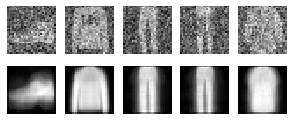

In [0]:
plt.figure(figsize=(5, 2))
for i, (x, y) in enumerate(val_ds.take(5)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(dec(cod(x)).numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

## Autocodificador disperso
Se define un autocodificador quita ruido disperso agregando un regularizador de activaciones sobre la salida del codificador:



In [0]:
cod_d = Sequential([Dense(1000, activation='sigmoid', input_shape=(784,)),
                    Dense(500, activation='sigmoid'),
                    Dense(200, activation='sigmoid'),
                    Dense(100, activation='sigmoid', activity_regularizer=l1(10e-5))])
dec_d = Sequential([Dense(200, activation='sigmoid', input_shape=(100,)),
                    Dense(500, activation='sigmoid'),
                    Dense(1000, activation='sigmoid'),
                    Dense(784, activation='sigmoid')])
ac_d = Model(cod_d.inputs, dec_d(cod_d.outputs))
ac_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               1406484   
Total params: 2,812,284
Trainable params: 2,812,284
Non-trainable params: 0
_________________________________________________

Se entrena el autocodificador por 3 épocas con el optimizador Adam y función de pérdida de error cuadrático medio:

In [0]:
@tf.function
def paso_ent(x, y, modelo, fn_perdida, optimizador):
    with tf.GradientTape() as cinta:
        y_pred = modelo(x)
        perdida = fn_perdida(y, y_pred)
    gradientes = cinta.gradient(perdida, modelo.trainable_variables)
    optimizador.apply_gradients(zip(gradientes, modelo.trainable_variables))
    return y_pred

fn_perdida = tf.keras.losses.MeanSquaredError()
optimizador = tf.keras.optimizers.Adam()
perdida_ent = tf.keras.metrics.MeanSquaredError()
hist_perdida_ent = []
for epoca in range(3):
    for paso, (x, y) in enumerate(ent_ds):
        y_pred = paso_ent(x, y,  ac_d, fn_perdida, optimizador)
        perdida_ent(y, y_pred)
        
    perdida_ent_res = perdida_ent.result().numpy()
    perdida_ent.reset_states()
    hist_perdida_ent.append(perdida_ent_res)
     
    print('E{:2d} MSE(E)={:6.2f}'.format(epoca, 
                                         perdida_ent_res))

E 0 MSE(E)=  0.07
E 1 MSE(E)=  0.03
E 2 MSE(E)=  0.03


Se visualizan los resultados con algunos ejemplos del conjunto de validación:

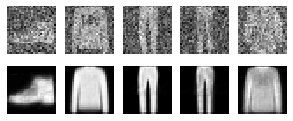

In [0]:
plt.figure(figsize=(5, 2))
for i, (x, y) in enumerate(val_ds.take(5)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(dec_d(cod_d(x)).numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

## Autocodificador convolucional

Se cargan las imágenes como tensor de $28 \times 28 \times 1$ para alimentarlas a la red convolucional y se genera una tubería de datos:

In [0]:
X_ent_im = I_ent.reshape(I_ent.shape[0], 28, 28, 1) / 255
X_val_im = I_val.reshape(I_val.shape[0], 28, 28, 1) / 255

ent_ds_c = tf.data.Dataset.from_tensor_slices((X_ent_im))
ent_ds_c = ent_ds_c.shuffle(60000)
ent_ds_c = ent_ds_c.map(procesa_imagen, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ent_ds_c = ent_ds_c.batch(64)
ent_ds_c = ent_ds_c.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds_c = tf.data.Dataset.from_tensor_slices((X_val_im))
val_ds_c = val_ds_c.map(procesa_imagen, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds_c = val_ds_c.batch(1)

Se define un autocodificador convolucional:

In [0]:
cod_c = Sequential([Conv2D(64, 3, activation='relu', padding='same', input_shape=(28,28,1)),
                    Conv2D(32, 3, activation='relu', padding='same'),
                    Conv2D(16, 3, activation='relu', padding='same'),
                    Flatten(),
                    Dense(100, activity_regularizer=l1(10e-3))])
dec_c = Sequential([Dense(784, input_shape=(100,)),
                    Reshape((28, 28, 1)),
                    Conv2DTranspose(16, 3, activation='relu', padding='same'),
                    Conv2DTranspose(32, 3, activation='relu', padding='same'),
                    Conv2DTranspose(64, 3, activation='relu', padding='same'),
                    Conv2DTranspose(1, 3, activation='sigmoid', padding='same')])
ac_c = Model(cod_c.inputs, dec_c(cod_c.outputs))
ac_c.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1254500   
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28, 1)         1030

Se entrena el autocodificador por 3 épocas con el optimizador Adam y función de pérdida de error cuadrático medio:

In [0]:
@tf.function
def paso_ent(x, y, modelo, fn_perdida, optimizador):
    with tf.GradientTape() as cinta:
        y_pred = modelo(x)
        perdida = fn_perdida(y, y_pred)
    gradientes = cinta.gradient(perdida, modelo.trainable_variables)
    optimizador.apply_gradients(zip(gradientes, modelo.trainable_variables))
    return y_pred

fn_perdida = tf.keras.losses.MeanSquaredError()
optimizador = tf.keras.optimizers.Adam()
perdida_ent = tf.keras.metrics.MeanSquaredError()
hist_perdida_ent = []
for epoca in range(3):
    for paso, (x, y) in enumerate(ent_ds_c):
        y_pred = paso_ent(x, y,  ac_c, fn_perdida, optimizador)
        perdida_ent(y, y_pred)
        
    perdida_ent_res = perdida_ent.result().numpy()
    perdida_ent.reset_states()
    hist_perdida_ent.append(perdida_ent_res)
     
    print('E{:2d} MSE(E)={:6.2f}'.format(epoca, 
                                         perdida_ent_res))

E 0 MSE(E)=  0.02
E 1 MSE(E)=  0.01
E 2 MSE(E)=  0.01


Se visualizan los resultados con algunos ejemplos del conjunto de validación:

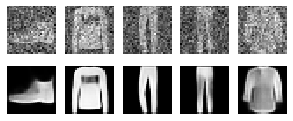

In [0]:
plt.figure(figsize=(5, 2))
for i, (x, y) in enumerate(val_ds_c.take(5)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(dec_c(cod_c(x)).numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
